## Project.4 Статистический анализ данных (тарифов сотовой связи)

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)

### Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». 
Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 
Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов:

### Тариф Смарт

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
  - минута разговора: 3 рубля
  - сообщение: 3 рубля
  - 1 Гб интернет-трафика: 200 рублей
  
### Тариф Ультра

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
  - минута разговора: 1 рубль
  - сообщение: 1 рубль
  - 1 Гб интернет-трафика: 150 рублей 
  
  #### Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.  

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### Описание данных

- Таблица `users` (информация о пользователях):
  - `user_id` — уникальный идентификатор пользователя
  - `first_name` — имя пользователя
  - `last_name` — фамилия пользователя
  - `age` — возраст пользователя (годы)
  - `reg_date` — дата подключения тарифа (день, месяц, год)
  - `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
  - `city` — город проживания пользователя
  - `tariff` — название тарифного плана
- Таблица `calls` (информация о звонках):
  - `id` — уникальный номер звонка
  - `call_date` — дата звонка
  - `duration` — длительность звонка в минутах
  - `user_id` — идентификатор пользователя, сделавшего звонок 
- `Таблица` messages (информация о сообщениях):
   - `id` — уникальный номер сообщения
   - `message_date` — дата сообщения
   - `user_id` — идентификатор пользователя, отправившего сообщение
- Таблица `internet` (информация об интернет-сессиях):
  - `id` — уникальный номер сессии
  - `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
  - `session_date` — дата интернет-сессии
  - `user_id` — идентификатор пользователя
- Таблица `tariffs` (информация о тарифах):
  - `tariff_name` — название тарифа
  - `rub_monthly_fee` — ежемесячная абонентская плата в рублях
  - `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
  - `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
  - `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
  - `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
  - `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
  - `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг.  Импорт библиотек

In [1]:
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import pandas as pd
import numpy as np
import math

### Шаг 1. Импорт данных

Поскольку данные хранятся в куче разных файлов, на данном этапе попробуем собрать в один датафрейм для более удобного анализа. Список файлов:
- /datasets/calls.csv. 
- /datasets/users.csv.
- /datasets/internet.csv. 
- /datasets/tariffs.csv. 
- /datasets/messages.csv. 

In [2]:
df_calls = pd.read_csv('datasets/calls.csv')
df_users = pd.read_csv('datasets/users.csv')
df_internet = pd.read_csv('datasets/internet.csv', index_col=0)
df_tariffs = pd.read_csv('datasets/tariffs.csv')
df_messages = pd.read_csv('datasets/messages.csv')

# version for MacOS:
#df_calls = pd.read_csv('datasets/calls.csv')

In [3]:
# выведем общую информацию по всем датасетам:
df_list = (df_users, df_tariffs, df_calls, df_messages, df_internet)
for df in df_list:
    df.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null

#### Наблюдения:
- В `df_calls`:
  `id` - строка (переведем в int), `call_date` - нужно перевести в DateTime
- В `df_users`:
     `churn_date` и `reg_date` - нужно изменить тип на DateTime
- В `df_internet`:
  столбец "Unnamed: 0" обработать (или index_col=0 при загрузке) , `session_date` - перевести в тип DateTime, `id`- строка (переведем в int)
- В `df_messages`:
    нужно изменить `message_date` в DateTime,  `id` - строка (переведем в int)

Посмотрим на сами данные:

In [4]:
df_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [5]:
df_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [6]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
df_messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [8]:
df_internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


### Шаг 1. Выводы:

- Теперь ясно почему `id` распознается, как строка: по сути это составной id из `user_id` и номера записи, которая к нему относится. Формально, user_id в данной связке избыточен, можно его убрать. Пока нет уверенности, что это необходимо, но, если будет нужно, можно будет разбить. Это касается всех таблиц.
- Безымянное поле по первым данным дублирует id самого датафрейма. Нужно это проверить, если подтвердится - удалить.
- Бросается в глаза нулевая продолжительность звонков. Скорее всего речь про звонки, когда человек на звонок не ответил. Либо это был входящий звонок и он не тарифицировался. Задержимся на на первой гипотизе
- Непонятных пропусков в данных нет (кроме churn_date)

### Шаг 2. Подготовьте данные (предобработка данных)


#### Тех.задание:  

Приведите данные к нужным типам;  

Найдите и исправьте ошибки в данных, если они есть.  

Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.  

Посчитайте для каждого пользователя:  

количество сделанных звонков и израсходованных минут разговора по месяцам;  

количество отправленных сообщений по месяцам;  

объем израсходованного интернет-трафика по месяцам;  

помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

#### 2.1. Cперва приведем данные к нужному виду. 

In [9]:
# Переведем все признаки с датами в формат DateTime для более удобной манипуляции в дальнейшем
df_users['churn_date'] = pd.to_datetime(
    df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(
    df_internet['session_date'], format='%Y-%m-%d')
df_calls['call_date'] = pd.to_datetime(
    df_calls['call_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(
    df_messages['message_date'], format='%Y-%m-%d')

In [10]:
# 2.2. Проверим на наличие дубликатов по всем датафреймам:
for df in df_list:
    print(df.duplicated().sum())
    print()

0

0

0

0

0



In [11]:
# 2.3. Обработаем продолжительность звонков, помня, что по тарифам округление идет в большую сторону:
df_calls['duration'] = df_calls['duration'].apply(np.ceil)

#### Шаг 2.4. Подготовка дополнительных данных (создание новых признаков)
Добавим в таблицу признаки, которые понадобятся нам в дальнейшем
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя

#### 2.4.1.Количество сделанных звонков и израсходованных минут по месяцам

In [12]:
# добавим признак "месяц" в df_calls
# и сделаем сводную таблицу продолжительности и кол-во разговоров по месяцам (учитывая года):
df_calls['month'] = df_calls['call_date'].astype('datetime64[M]')
df_calls_month = df_calls.pivot_table(index=['user_id', 'month'], values=[
                                      "duration"], aggfunc=['sum', 'count'])
df_calls_month.columns = ['month_call_duration', 'month_call_count']
df_calls_month

month_call_duration  month_call_count
user_id month                                            
1000    2018-05-01                159.0                22
        2018-06-01                172.0                43
        2018-07-01                340.0                47
        2018-08-01                408.0                52
        2018-09-01                466.0                58
...                                 ...               ...
1498    2018-10-01                247.0                41
1499    2018-09-01                 70.0                 9
        2018-10-01                449.0                68
        2018-11-01                612.0                74
        2018-12-01                492.0                69

[3174 rows x 2 columns]

#### 2.4.2. Количество отправленных сообщений по месяцам

In [13]:
# Тоже самое проделаем для "сообщений" в df_messages:
df_messages['month'] = df_messages['message_date'].astype('datetime64[M]')
df_messages_month = df_messages.pivot_table(index=['user_id', 'month'], values=[
                                            "message_date"], aggfunc=['count'])
df_messages_month.columns = ['month_message_count']
df_messages_month

month_message_count
user_id month                          
1000    2018-05-01                   22
        2018-06-01                   60
        2018-07-01                   75
        2018-08-01                   81
        2018-09-01                   57
...                                 ...
1498    2018-10-01                   42
1499    2018-09-01                   11
        2018-10-01                   48
        2018-11-01                   59
        2018-12-01                   66

[2717 rows x 1 columns]

#### 2.4.3. Кол-во израсходованного интернет-трафика по месяцам

In [14]:
# Подготовим сводную таблицу для объема израсходованного интернет-трафика по месяцам
df_internet['month'] = df_internet['session_date'].astype('datetime64[M]')
df_internet_month = df_internet.pivot_table(
    index=['user_id', 'month'], values=["mb_used"], aggfunc=['sum'])
df_internet_month.columns = ['month_mb_used']
df_internet_month

month_mb_used
user_id month                    
1000    2018-05-01        2253.49
        2018-06-01       23233.77
        2018-07-01       14003.64
        2018-08-01       14055.93
        2018-09-01       14568.91
...                           ...
1498    2018-10-01       20579.36
1499    2018-09-01        1845.75
        2018-10-01       17788.51
        2018-11-01       17963.31
        2018-12-01       13055.58

[3203 rows x 1 columns]

<div class="alert alert-info"> <b> Комментарий студента #4:</b> Сделаем правильное округление интернет трафика: </div>

In [15]:
# добавим признак с  округленным кол-вом интернет трафика (до целых гб):
df_internet_month['month_gb_rounded'] = (
    df_internet_month['month_mb_used']/1024).apply(np.ceil).astype(int)
df_internet_month

month_mb_used  month_gb_rounded
user_id month                                      
1000    2018-05-01        2253.49                 3
        2018-06-01       23233.77                23
        2018-07-01       14003.64                14
        2018-08-01       14055.93                14
        2018-09-01       14568.91                15
...                           ...               ...
1498    2018-10-01       20579.36                21
1499    2018-09-01        1845.75                 2
        2018-10-01       17788.51                18
        2018-11-01       17963.31                18
        2018-12-01       13055.58                13

[3203 rows x 2 columns]

#### 2.4.4.Расчитаем месячную выручку с каждого пользователя

In [16]:
# Для этого сперва нужно объеденить данные из трех таблиц
df_data = df_calls_month.combine_first(df_messages_month)
df_data = df_data.combine_first(df_internet_month)

# Добавим в итоговую таблицу признаки название тарифа и город
df_data = df_data.reset_index(level='month')
df_usage_total = df_data.merge(
    df_users[['user_id', 'tariff', 'city']], on='user_id', how='left')

df_usage_total

,user_id,month,month_call_count,month_call_duration,month_gb_rounded,month_mb_used,month_message_count,tariff,city
0,1000,2018-05-01,22.0,159.0,3.0,2253.49,22.0,ultra,Краснодар
1,1000,2018-06-01,43.0,172.0,23.0,23233.77,60.0,ultra,Краснодар
2,1000,2018-07-01,47.0,340.0,14.0,14003.64,75.0,ultra,Краснодар
3,1000,2018-08-01,52.0,408.0,14.0,14055.93,81.0,ultra,Краснодар
4,1000,2018-09-01,58.0,466.0,15.0,14568.91,57.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1498,2018-10-01,41.0,247.0,21.0,20579.36,42.0,smart,Владикавказ
3210,1499,2018-09-01,9.0,70.0,2.0,1845.75,11.0,smart,Пермь
3211,1499,2018-10-01,68.0,449.0,18.0,17788.51,48.0,smart,Пермь
3212,1499,2018-11-01,74.0,612.0,18.0,17963.31,59.0,smart,Пермь


#### 2.4.5. Посчитаем помесячную выручку и добавим в таблицу

In [18]:
# будем считать таким образом:
# вычтем бесплатный лимит из суммарного количества звонков, сообщений и трафика;
# остаток умножим на значение из тарифного плана;
# прибавим абонентскую плату, соответствующую тарифному плану.

def calculate_under_limit(row, current_tariff_data, row_filed_name, tariff_field_name):
    """
    функция считает расход ресурсов сверх тарифного лимита"""

    result = 0
    if (row[row_filed_name] > current_tariff_data[tariff_field_name]):
        result = row[row_filed_name] - current_tariff_data[tariff_field_name]

    return result


def calculate_proceeds(row):
    tariff_index_dict = {'smart': 0, 'ultra': 1}
    tariff_index = tariff_index_dict[row['tariff']]
    current_tariff_data = df_tariffs.loc[tariff_index]

    minutes_under_limit = calculate_under_limit(
        row, current_tariff_data, 'month_call_duration', 'minutes_included')
    mb_under_limit = calculate_under_limit(
        row, current_tariff_data, 'month_mb_used', 'mb_per_month_included')
    messages_under_limit = calculate_under_limit(
        row, current_tariff_data, 'month_message_count', 'messages_included')

# вычисляем сумму по ГБ
    proceeds_by_traffic = mb_under_limit * \
        current_tariff_data['rub_per_gb']  # works
    proceeds_by_traffic = int(
        np.ceil(mb_under_limit / 1024) * current_tariff_data['rub_per_gb'])

    #proceeds_by_traffic = month_gb_rounded * current_tariff_data['rub_per_gb']

    result = (minutes_under_limit * current_tariff_data['rub_per_minute']
              + messages_under_limit * current_tariff_data['rub_per_message']
              + proceeds_by_traffic
              + current_tariff_data['rub_monthly_fee'])

    return result

In [19]:
df_usage_total['profit'] = df_usage_total.apply(calculate_proceeds, axis=1)
# посмотрим на итоговый результат:
df_usage_total.head(15)

,user_id,month,month_call_count,month_call_duration,month_gb_rounded,month_mb_used,month_message_count,tariff,city,profit
0,1000,2018-05-01,22.0,159.0,3.0,2253.49,22.0,ultra,Краснодар,1950.0
1,1000,2018-06-01,43.0,172.0,23.0,23233.77,60.0,ultra,Краснодар,1950.0
2,1000,2018-07-01,47.0,340.0,14.0,14003.64,75.0,ultra,Краснодар,1950.0
3,1000,2018-08-01,52.0,408.0,14.0,14055.93,81.0,ultra,Краснодар,1950.0
4,1000,2018-09-01,58.0,466.0,15.0,14568.91,57.0,ultra,Краснодар,1950.0
5,1000,2018-10-01,57.0,350.0,15.0,14702.49,73.0,ultra,Краснодар,1950.0
6,1000,2018-11-01,43.0,338.0,15.0,14756.47,58.0,ultra,Краснодар,1950.0
7,1000,2018-12-01,46.0,333.0,10.0,9817.61,70.0,ultra,Краснодар,1950.0
8,1001,2018-11-01,59.0,430.0,18.0,18429.34,NaN,smart,Москва,1150.0
9,1001,2018-12-01,63.0,414.0,14.0,14036.66,NaN,smart,Москва,550.0


### Итоги по шагу 2:
Привели данные к нужному виду (типу), избавились от ненужного признака (дублировал индексы). Дубликатов в данных нет.  
Внутренний идентификатор пока не трогали, т.к. кажется он нам не понадобится в дальнейшем анализе.  

Пока также не трогаем нулевые звонки, т.к. эти данные никак не повлияют на сумму и выручку, но могут быть полезны в анализе других параметров.  

Помимо этого мы округлили до целого количество минут и до гигабайтов количество мегабайтов за месяц, чтобы корректно рассчитать, сколько требуется и сколько на самом деле пользователю необходимо будет заплатить за услуги связи.
Мы подготовили дополнительные данные (признаки), которые потребуются нам для дальнейшего анализа в проекте.
При этом, мы заранее округлили все нужные нам значения и теперь можем быть уверены, что расчеты будут выполнены верно.

### Шаг 3. Анализ данных.

Проведем анализ поведения клиентов оператора, исходя из выборки, ответив на вопросы:
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитаем среднее количество, дисперсию и стандартное отклонение
- Построим гистограммы. Опишем распределения.

#### 3.1. Построим  гистограммы для анализа.

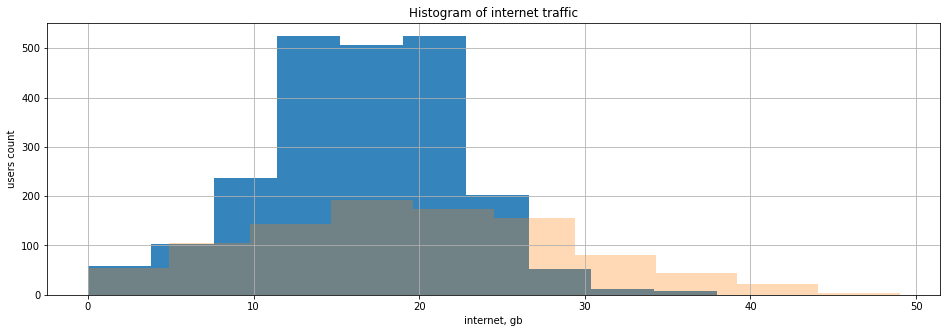

In [20]:
# Поделим наши датафреймы по тарифам, чтобы дальше просто было удобней с этим работать
df_smart = df_usage_total.query('tariff == "smart"')
df_ultra = df_usage_total.query('tariff == "ultra"')
# Построим гистограмму для интернет-траффика
# Опятным путем подбираем интервалы для наших непрерывных значений
df_smart['month_gb_rounded'].hist(bins=10, figsize=(16, 5), alpha=0.9)
df_ultra['month_gb_rounded'].hist(bins=10, figsize=(16, 5), alpha=0.3)
plt.title("Histogram of internet traffic")
plt.xlabel("internet, gb")
plt.ylabel("users count")
# sns.set(font_scale=1.8)
plt.show()

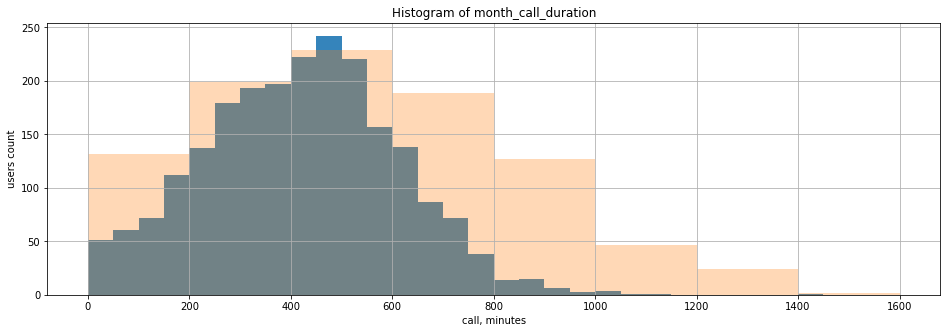

In [21]:
# Аналогично построим гистограмму для звонков
# На этот раз сформируем корзины автоматически

def make_bins(step, maximum):
    maximum_calculated = int(np.ceil(maximum / 100) * 100)
    elements_count = int(maximum_calculated / step) + 1

    bins = []
    for bin_element in range(elements_count):
        bins.append(bin_element * step)

    return bins


# шаг также подбираем индивидуально, это сильно влияет на то, каким будет распределение
# вероятно это связано с количеством данных и их разнородностью по тарифу ультра
bins_smart = make_bins(50, df_smart['month_call_duration'].max())
bins_ultra = make_bins(200, df_ultra['month_call_duration'].max())

df_smart['month_call_duration'].hist(
    bins=bins_smart, figsize=(16, 5), alpha=0.9)
df_ultra['month_call_duration'].hist(
    bins=bins_ultra, figsize=(16, 5), alpha=0.3)
plt.title("Histogram of month_call_duration")
plt.xlabel("call, minutes")
plt.ylabel("users count")
plt.show()

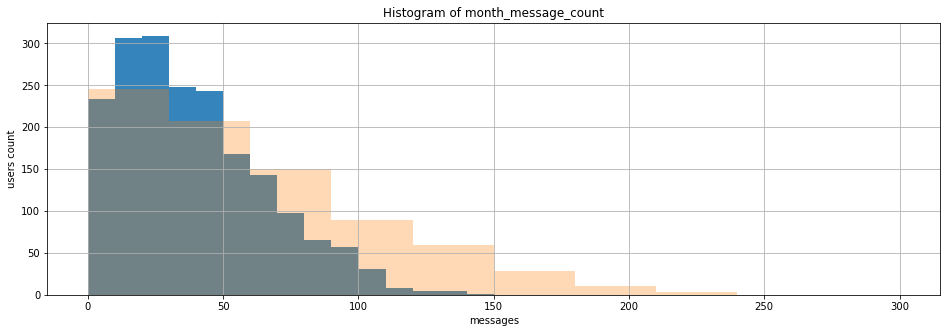

In [22]:
# Аналогично построим гистограммы для сообщений (month_message_count)

bins_smart = make_bins(10, df_smart['month_message_count'].max())
bins_ultra = make_bins(30, df_ultra['month_message_count'].max())

df_smart['month_message_count'].hist(
    bins=bins_smart, figsize=(16, 5), alpha=0.9)
df_ultra['month_message_count'].hist(
    bins=bins_ultra, figsize=(16, 5), alpha=0.3)
plt.title("Histogram of month_message_count")
plt.xlabel("messages")
plt.ylabel("users count")
plt.show()

#### Выводы по гистограммам

- Интернет-траффик и количество минут разговоров имеют нормальное распределение
- Количество сообщений описывается Пуассоновским распределением
- Количество минут для обоих тарифов скошено влево
- Количество трафика для тарифа ультра немного скошено вправо

#### 3.2. Cреднее, дисперсия и стандартное отклонение

In [23]:
# Посчитаем среднее, дисперсию и стандартное отклонение для наших тарифов
def print_params_data(df):
    params_list = ['month_gb_rounded', 'month_call_duration',
                   'month_message_count', 'profit']

    for param in params_list:
        print(param + ':')
        print('AVG = ', round(df[param].mean(), 2))  # среднее
        print('MED = ', round(df[param].median(), 2))  # медиана
        # дисперсия, по выборке
        print('VAR = ', round(np.var(df[param], ddof=1), 2))
        # стандартное отклонение, по выборке
        print('STD = ', round(np.std(df[param], ddof=1), 2))
        print()


# выведем данные для смарт-тарифа
print('TARIFF: SMART')
print_params_data(df_smart)

TARIFF: SMART
month_gb_rounded:
AVG =  16.34
MED =  17.0
VAR =  32.92
STD =  5.74

month_call_duration:
AVG =  419.06
MED =  423.0
VAR =  35844.19
STD =  189.33

month_message_count:
AVG =  38.72
MED =  34.0
VAR =  717.59
STD =  26.79

profit:
AVG =  1289.97
MED =  1023.0
VAR =  669785.71
STD =  818.4



In [24]:
# Выведем данные для ультра тарифа
print('TARIFF: ULTRA')
print_params_data(df_ultra)

TARIFF: ULTRA
month_gb_rounded:
AVG =  19.69
MED =  19.0
VAR =  94.15
STD =  9.7

month_call_duration:
AVG =  545.45
MED =  528.0
VAR =  94203.42
STD =  306.93

month_message_count:
AVG =  61.16
MED =  51.0
VAR =  2109.66
STD =  45.93

profit:
AVG =  2070.15
MED =  1950.0
VAR =  141516.75
STD =  376.19



### Шаг 3. Вывод

- Несмотря на то, что в уроках такие здоровые значения дисперсии и стандартного отклонения мы еще не видели, в контексте используемых единиц и временного промежутка, кажется что все в порядке. :)
- Медиана слабо отличается от среднего. Поэтому можно считать, что выбросов нет и спокойно работать со средним, т.к. в контексте наших вопросов это более интересная метрика.
- Пользователи тарифа ультра активней используют возможности своего тарифа
- А пользователи смарт плохо укладываются в ограничения своего тарифа и серьезно переплачивают

#### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

- Если говорить в среднем, то:
  - SMART
   - Трафик: 16,34 ГБ
   - Продолжительность звонков: 419 минут
   - Сообщений: 39
  - ULTRA
   - Трафик: 19,7 ГБ
   - Продолжительность звонков: 545 минут
   - Сообщений: 61


### Шаг 4. Проверим гипотезы


#### Тех.задание:
Проверьте гипотезы:  

средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;  

средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.  

Пороговое значение alpha задайте самостоятельно.  

Поясните:  

как вы формулировали нулевую и альтернативную гипотезы;  

какой критерий использовали для проверки гипотез и почему.  


#### Шаг 4.1. Выручка пользователей тарифов "Смарт" и  "Ультра"

Для начала сформулируем гипотезы H0 и H1.

Гипотеза H0: Средняя выручка от пользователей тарифа "Смарт" и тарифа "Ультра" одинакова (т.е. мы получаем одни деньги и там, и там)  

Гипотеза H1: Выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается

Сформулируем это в коде

In [31]:
# Перенесем гипотезы в код
H0 = 'Не можем отвергнуть гипотизу - средняя выручка от пользователей тарифа "Смарт" и тарифа "Ультра" одинакова'
H1 = 'Можем отвергнуть нулевую гипотезу, выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается'

# зададим критический уровень статистической значимости в 5%
alpha = 0.05 

# equal_var = False, т.к. совокупности по параметрам различаются
results = st.ttest_ind(df_smart['profit'], df_ultra['profit'], equal_var = False)

if (results.pvalue < alpha):
    print(H1)
else:
    print(H0)
    
# выведем среднюю выручку по тарифам:
print("Средняя выруучка от тарифа  'Смарт': ",df_smart['profit'].mean())
print("Средняя выруучка от тарифа  'Ультра': ",df_ultra['profit'].mean())
print(results)

Можем отвергнуть нулевую гипотезу, выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается
Средняя выруучка от тарифа  'Смарт':  1289.9735307312696
Средняя выруучка от тарифа  'Ультра':  2070.1522842639592
Ttest_indResult(statistic=-37.019021231454644, pvalue=4.2606313931076085e-250)


#### Шаг 4.2.  Выручка пользователей из Москвы и других регионов

Для начала сформулируем гипотезы H0 и H1.

Гипотеза H0: Средняя выручка от пользователей Москвы и регионов одинакова  

Гипотеза H1: Средняя выручка от пользователей Москвы и регионов различается

In [25]:
# выделим отдельно пользователей из Москвы и не из нее
df_moscow = df_usage_total.query('city == "Москва"')
df_other = df_usage_total.query('city != "Москва"')

# Перенесем гипотезы в код
alpha = 0.05

H0 = 'Не можем отвергнуть гипотизу - cредняя выручка от пользователей Москвы и регионов одинакова'
H1 = 'Можем отвергнуть нулевую гипотезу, cредняя выручка от пользователей Москвы и регионов различается'

# equal_var = True, т.к. совокупности по параметрам не должны различаться
results = st.ttest_ind(df_moscow['profit'], df_other['profit'], equal_var=True)

if (results.pvalue < alpha):
    print(H1)
else:
    print(H0)

# выведем среднюю выручку по регионам:
print("Средняя выручка в городе Москва:", df_moscow['profit'].mean())
print("Средняя выручка в др регионах:", df_other['profit'].mean())
print(results)

Не можем отвергнуть гипотизу - cредняя выручка от пользователей Москвы и регионов одинакова
Средняя выручка в городе Москва: 1546.7135842880523
Средняя выручка в др регионах: 1524.9362274298885
Ttest_indResult(statistic=0.606816942705698, pvalue=0.5440152911670224)


#### Вывод по гипотезам

- Мы отвергли гипотезу о равенстве выручки пользователей по тарифам, однако степень этой разницы и знак нужно исследовать дополнтельно
- При этом внезапно, с большой долей вероятности средняя выручка пользователей Москвы и регионов оказалась одинакова

### Шаг 5. Общие выводы:

Мы провели большой серьезный анализ 2 тарифов, чтобы ответить на главный вопрос: какой тариф лучше?  

Для этого мы объеденили данные из разных источников, провели обработку данных, затем сгенерировали новые признаки для дальнейшего результативного исследования.  

Для решения поставленной задачи сделали помесячную сводную таблицу звонков, сообщений и интернет трафика для каждого пользователя, рассчитали выручку исходя из указанных тарифов.
Полученные данные (звонки, сообщения, интернет трафик) были исследованы на распределение с помощью гистограмм.  

После проверки данных рассчитали средние значения по услугам (звонки, сообщения, интернет трафик) пользователей по каждому тарифу.  

Получили следующие показатели:  

Тариф ULTRA (в среднем):  

 - Трафик: 19,7 ГБ  
 
 - Звонки: 545 минут  
 
 - Сообщения: 62  
 
 - выручка: 2070.15 руб.  
 
 Тариф SMART (в среднем):  
 
 - Трафик: 16,2 ГБ  
 
 - Звонки: 419 минут 
 
 - Сообщения: 39  
 
 - выручка: 1289.97 руб.  
 

Имея указанные данные на руках была произведена проверка гипотез:  

1.Мы отвергли гипотезу о равенстве выручки пользователей по тарифам. Судя по среднему показателю выручки Тарифа ULTRA (2070.15 руб.) и Тарифа SMART (1289.97 руб.), Тарифа ULTRA для компании гораздо выгоднее.   

2. При этом внезапно, с большой долей вероятности средняя выручка пользователей Москвы и регионов оказалась почти одинаковой.  

В целом, предоставляемое тарифом Ультра зачастую избыточно и можно считать, что пользователи переплачивают.  